<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

In [35]:
saved_model = load_model('/content/drive/My Drive/xai_model/LG_model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/pitted_surface_294.xml'
image_path = "/content/drive/My Drive/NEU orig/PS/PS_294.bmp"

In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

In [0]:
shap_Cr = '/content/drive/My Drive/NEU orig/Cr/*.bmp'
shap_In = '/content/drive/My Drive/NEU orig/In/*.bmp'
shap_PS = '/content/drive/My Drive/NEU orig/PS/*.bmp'
shap_Pa = '/content/drive/My Drive/NEU orig/Pa/*.bmp'
shap_RS = '/content/drive/My Drive/NEU orig/RS/*.bmp'
shap_Sc = '/content/drive/My Drive/NEU orig/Sc/*.bmp'

shap_data = [shap_Cr, shap_In, shap_PS, shap_Pa, shap_RS, shap_Sc]

[[9.5502104e-09 8.1120572e-07 9.9999511e-01 2.9451867e-06 9.9716272e-07
  2.4741992e-08]]
[2]
Pitted Surface


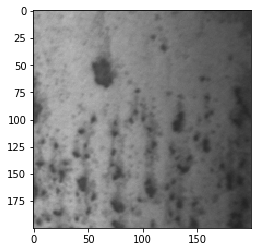

In [49]:
img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255
result = saved_model.predict(img)
print(result)

prediction = result.argmax(axis=-1)
print(prediction)

output = labels[int(prediction)]
print(output)

[[66, 66, 197, 192], [1, 90, 64, 199], [51, 38, 78, 74]]


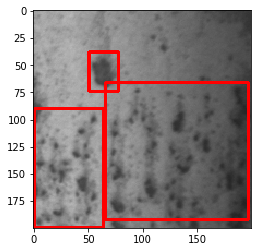

In [50]:
b_img = cv2.imread(image_path)

def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)
print(boxes)

for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [51]:
!pip install shap

In [0]:
# %%time
# import glob
# cv_img = []

# for i in range(len(shap_data)):
#   for ig in glob.glob(shap_data[i]):
#     n = cv2.imread(ig)
#     cv_img.append(n)

# shap_background = np.array(cv_img)

#np.save('/content/drive/My Drive/XAI_results/shap_background.npy', shap_background)


In [52]:
shap_background = np.load('/content/drive/My Drive/XAI_results/shap_background.npy')
shap_background.shape

(1800, 200, 200, 3)

(1, 200, 200, 3)

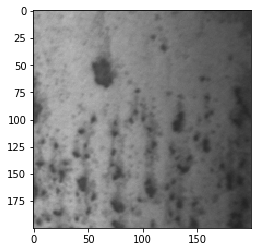

In [53]:
shap_test = image.load_img(image_path) #, grayscale=True)
plt.imshow(shap_test)

shap_test = image.img_to_array(shap_test)
shap_test = np.expand_dims(shap_test, axis=0)
#shap_test /= 255
#shap_test = preprocess_input(shap_test)
shap_test.shape

In [54]:
for i in range(len(saved_model.layers)):
  print(i , saved_model.layers[i])

0 <keras.engine.input_layer.InputLayer object at 0x7f23c8f68c50>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7f23c8f68cc0>
2 <keras.layers.convolutional.Conv2D object at 0x7f23c8f68cf8>
3 <keras.layers.normalization.BatchNormalization object at 0x7f23c8f74048>
4 <keras.layers.advanced_activations.ReLU object at 0x7f23c8f74160>
5 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f23c8f74198>
6 <keras.layers.normalization.BatchNormalization object at 0x7f23c8f74208>
7 <keras.layers.advanced_activations.ReLU object at 0x7f23c8f744e0>
8 <keras.layers.convolutional.Conv2D object at 0x7f23c8f74518>
9 <keras.layers.normalization.BatchNormalization object at 0x7f23c8f746a0>
10 <keras.layers.advanced_activations.ReLU object at 0x7f23c8f747b8>
11 <keras.layers.convolutional.ZeroPadding2D object at 0x7f23c8f747f0>
12 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f23c8f74828>
13 <keras.layers.normalization.BatchNormalization object at 0x7f23c8f74898>
14 <keras.layers.

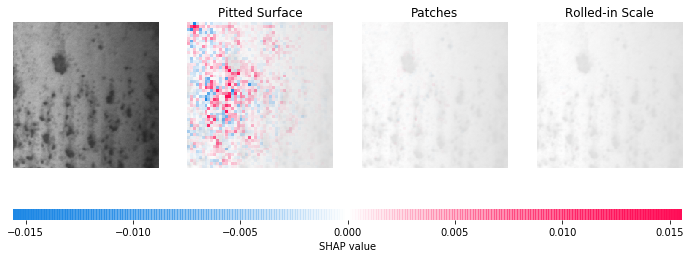

CPU times: user 9.17 s, sys: 743 ms, total: 9.91 s
Wall time: 10.1 s


In [55]:
%%time
import keras.backend as K
import shap
m = 16

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[m].input, saved_model.layers[-1].output),
                           map2layer(preprocess_input(shap_background.copy()),m), local_smoothing = 0)

shap_values, indexes = e.shap_values(map2layer(shap_test, m), ranked_outputs=3)

index_names = np.vectorize(lambda l: labels[l])(indexes)

shap.image_plot(shap_values, shap_test, index_names)